In [1]:
import os

import numpy
import pandas
import yaml
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt

figure_directory = "./figures"
os.makedirs(figure_directory, exist_ok=True)

In [3]:
os.listdir("./data/toktarova_et_al_2019/")

['Population.csv',
 'ElectricityperCapita.csv',
 'GDPperCap 2015.5.2050.10.2100.csv',
 'Real load hourly data.csv',
 'AnnualDemand.csv',
 'Data.csv',
 'GDPperCapita.csv',
 'Firstdayofyear.csv',
 'Peak.csv',
 'References.csv']

In [4]:
with open("./data/gegis__all_countries.yaml", "r") as file:
    data = yaml.safe_load(file)

In [5]:
items = data["items"]
gegis_countries = [[item["country_name"], item["country_code"]] for item in items]

In [6]:
gegis_country_codes = numpy.array(gegis_countries).T[1]

In [7]:
gegis_countries

[['Austria', 'AT'],
 ['Belgium', 'BE'],
 ['Bosnia and Herzegovina', 'BA'],
 ['Bulgaria', 'BG'],
 ['Croatia', 'HR'],
 ['Cyprus', 'CY'],
 ['Czech Republic', 'CZ'],
 ['Denmark', 'DK'],
 ['Estonia', 'EE'],
 ['Finland', 'FI'],
 ['France', 'FR'],
 ['Germany', 'DE'],
 ['Greece', 'GR'],
 ['Hungary', 'HU'],
 ['Iceland', 'IS'],
 ['Ireland', 'IE'],
 ['Italy', 'IT'],
 ['Latvia', 'LV'],
 ['Lithuania', 'LT'],
 ['Netherlands', 'NL'],
 ['North Macedonia', 'MK'],
 ['Norway', 'NO'],
 ['Poland', 'PL'],
 ['Portugal', 'PT'],
 ['Romania', 'RO'],
 ['Serbia', 'RS'],
 ['Slovakia', 'SK'],
 ['Slovenia', 'SI'],
 ['Spain', 'ES'],
 ['Sweden', 'SE'],
 ['Switzerland', 'CH'],
 ['United Kingdom', 'GB'],
 ['Canada', 'CA'],
 ['Mexico', 'MX'],
 ['Argentina', 'AR'],
 ['Brazil', 'BR'],
 ['Chile', 'CL'],
 ['Australia', 'AU'],
 ['New Zealand', 'NZ'],
 ['Kenya', 'KE'],
 ['Saudi Arabia', 'SA'],
 ['South Korea', 'KR'],
 ['Sri Lanka', 'LK'],
 ['Türkiye', 'TR']]

## Features

"""

We take time series of hourly electricity demand for 44 countries from Toktarova et al. [15] and fit a gradient boosting regression model [32] to demand time series for each country normalized to their annual mean

Estimates of annual country-level annual electricity generation in 2050 were produced by extrapolating annual demand in 2016 [33] using regional demand growth in the SSP2-26 scenario

Therefore we chose to train our model on ten independent var­
iables: 

(i + ii) annual per-capita electricity demand and purchase-power adjusted GDP (for prediction, we extrapolated this to 2050 using the SSP2 scenario in a similar way to demand as above), 

(iii) average hourly temperature profiles over the year in the 3 most densely populated areas of each country [35,36], 

(iv) the mean annual temperature level,

(v) the 1st temperature percentile across the year (to represent how low the temperature dips go),

(vi) the 99th percentile (to represent how high temperature spikes go),

(vii) hour of the day,

(viii) a weekday/weekend indicator,

(ix) mean monthly temperature levels, and

(x) a temperature-based ranking of months of the year
(where the first month is the coldest month, and the month ranked last is the warmest across the year).
The temperature ranking of months was chosen in order to reflect that different countries have summer in different calendar months.

"""



### (i) annual per-capita electricity demand

In [8]:
ElectricityPerCapita = pandas.read_csv(
    "./data/toktarova_et_al_2019/ElectricityperCapita.csv", index_col=0, header=1
)

In [9]:
ElectricityPerCapita.columns = [
    int(float(col_name)) if col_name.split(".")[0].isdigit() else col_name
    for col_name in ElectricityPerCapita.columns
]

In [10]:
ElectricityPerCapita.head()

,Countries,Continents,SRegion,2009,2010,2011,2012,2013,2014,2015,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
Code,,,,,,,,,,,,,,,,,,,,,
1,Afghanistan,Asia-Pacific,India_SAARC,NaN,NaN,NaN,NaN,137.101712,133.966935,144.395483,...,17624.624960,17687.097102,17744.647413,17797.642291,17846.424921,17891.316151,17932.615413,17970.601709,18005.534605,18042.450631
2,Albania,Europe,Europe,NaN,NaN,NaN,2643.873655,2627.239093,2659.396326,2784.365974,...,17707.115074,17754.295409,17798.312225,17839.347976,17877.578900,17913.174581,17946.297631,17977.103475,18005.740240,18037.176698
3,Algeria,Africa,MENA,NaN,NaN,NaN,NaN,NaN,1417.816396,1589.823258,...,17803.171328,17837.323936,17869.000999,17898.357409,17925.541849,17950.696535,17973.957043,17995.452226,18015.304196,18038.456462
4,Andorra,Europe,Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Angola,Africa,Africa,NaN,NaN,NaN,NaN,NaN,NaN,377.148110,...,17269.345036,17370.709694,17467.169776,17558.924431,17646.171148,17729.104683,17807.916168,17882.792373,17953.915119,18026.287910


In [11]:
import pycountry


def search_pycountry(country_name: str) -> str | None:
    try:
        # Try to find the country
        country = pycountry.countries.search_fuzzy(country_name)[0]
        return country.alpha_2
    except LookupError:
        return None


def get_country_codes(country_names):
    country_codes = []
    for country_name in country_names:
        found_country_code = search_pycountry(country_name)
        if not (found_country_code):
            print("Not Found:", country_name)

        country_codes.append(found_country_code)
    return country_codes

In [12]:
ElectricityPerCapita.insert(
    1, "country_code", get_country_codes(ElectricityPerCapita["Countries"])
)

Not Found: Area under dispute
Not Found: Bahamas. The
Not Found: Bosnia-Herzegovina
Not Found: Bouvet Island (uninhabited)
Not Found: Myanmar former Burma
Not Found: Cambodia (Formerly Kampuchea)
Not Found: Cape Verde
Not Found: Congo. Democratic Republic of the (Formerly Zaire)
Not Found: Congo. Republic of the
Not Found: Crozet Islands (France)
Not Found: Falkland Islands (Islas Malvinas)
Not Found: French Guiana (France)
Not Found: Gambia. The
Not Found: Guadeloupe (France)
Not Found: Guinea - Bissau
Not Found: Ile Amsterdam (France)
Not Found: Ivory Coast
Not Found: Kerguelen Islands (France)
Not Found: Korea. Democratic Peoples Republic
Not Found: Korea. Republic of
Not Found: Martinique (France)
Not Found: Vanuatu former New Hebrides
Not Found: Norfolk Island (Australia)
Not Found: Prince Edward Islands (South Africa)
Not Found: Reunion (France)
Not Found: St. Helena
Not Found: St. Lucia
Not Found: St. Vincent and the Grenadines
Not Found: Swaziland
Not Found: Tanzania. United Re

In [13]:
# Print gegis countries not found by search
for code in gegis_country_codes:
    if code not in ElectricityPerCapita["country_code"].values:
        print(code)

BA
RS
KR
TR


In [14]:
# Adjust the missing countries
index_cc_BA = ElectricityPerCapita[
    ElectricityPerCapita["Countries"] == "Bosnia-Herzegovina"
].index
ElectricityPerCapita.loc[index_cc_BA, "country_code"] = "BA"

index_cc_RS = ElectricityPerCapita[
    ElectricityPerCapita["Countries"] == "Serbia (former Yugoslavia)"
].index
ElectricityPerCapita.loc[index_cc_RS, "country_code"] = "RS"

index_cc_KR = ElectricityPerCapita[
    ElectricityPerCapita["Countries"] == "Korea. Republic of"
].index
ElectricityPerCapita.loc[index_cc_KR, "country_code"] = "KR"

index_cc_TR = ElectricityPerCapita[ElectricityPerCapita["Countries"] == "Turkey"].index
ElectricityPerCapita.loc[index_cc_TR, "country_code"] = "TR"

In [15]:
list_ids_gegis = []
for i in range(len(ElectricityPerCapita)):
    current_row = ElectricityPerCapita.iloc[i]

    if current_row["country_code"] in gegis_country_codes:
        list_ids_gegis += [i]

In [16]:
ElectricityPerCapita = ElectricityPerCapita.iloc[list_ids_gegis]

In [17]:
# Drop manually found incorrect countries (usually territories)
ElectricityPerCapita = ElectricityPerCapita.drop([207, 211, 220])

In [18]:
ElectricityPerCapita[["country_code", 2015]]

,country_code,2015
Code,,
9,AR,3042.742899
11,AU,8985.049043
12,AT,8147.214043
19,BE,7542.514249
25,BA,3245.548163
28,BR,2795.079254
30,BG,5401.970000
35,CA,9527.951473
39,CL,3861.453167


In [19]:
toktarova_indices = ElectricityPerCapita.index

In [20]:
numpy.savetxt("./data/train/toktarova_indices.txt", toktarova_indices)

In [21]:
ElectricityPerCapita_2015 = ElectricityPerCapita[["country_code", 2015]].copy()
ElectricityPerCapita_2015.rename(
    columns={2015: "ElectricityPerCapita_2015"}, inplace=True
)

In [22]:
ElectricityPerCapita_2015.head()

,country_code,ElectricityPerCapita_2015
Code,,
9,AR,3042.742899
11,AU,8985.049043
12,AT,8147.214043
19,BE,7542.514249
25,BA,3245.548163


## (ii) purchase-power adjusted GDP 

In [23]:
GDP_PPP = pandas.read_csv(
    "./data/toktarova_et_al_2019/GDPperCapita.csv", index_col=0, header=1
)

In [24]:
GDP_PPP.columns = [
    int(float(col_name)) if col_name.split(".")[0].isdigit() else col_name
    for col_name in GDP_PPP.columns
]

In [25]:
GDP_PPP[2015].count()

np.int64(209)

In [26]:
GDP_PPP = GDP_PPP.loc[toktarova_indices]

In [27]:
GDP_PPP.insert(1, "country_code", ElectricityPerCapita["country_code"])

In [28]:
GDP_PPP.head()

,Countries,country_code,Continents,SRegion,1990,1991,1992,1993,1994,1995,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
Code,,,,,,,,,,,,,,,,,,,,,
9,Argentina,AR,Americas,S America,NaN,NaN,NaN,NaN,NaN,NaN,...,86413.457614,86619.323619,86811.093372,86989.533276,87155.396873,87309.420359,87452.318903,87584.783702,87707.479717,87855.731355
11,Australia,AU,Asia-Pacific,SE Asia,21482.763579,21130.110814,20958.563029,21597.178853,22232.676622,22817.776245,...,87578.177439,87639.100855,87695.845490,87748.692355,87797.904320,87843.727181,87886.390680,87926.109479,87963.084078,87997.501699
12,Austria,AT,Europe,Europe,23393.185071,23957.893300,24191.744461,24119.470637,24603.973307,25221.757630,...,87174.900482,87301.069941,87420.316407,87532.998481,87639.458551,87740.023254,87835.003961,87924.697275,88009.385545,88089.337374
19,Belgium,BE,Europe,Europe,22865.408104,23198.184791,23457.903718,23141.691297,23814.956850,24331.872447,...,86171.835970,86425.540285,86665.069264,86891.112496,87104.338146,87305.392073,87494.897206,87673.453135,87841.635922,87999.998060
25,Bosnia-Herzegovina,BA,Europe,Europe,NaN,NaN,NaN,NaN,1084.513725,1348.247015,...,85534.130159,85892.069162,86226.353699,86538.264126,86829.051377,87099.931519,87352.081358,87586.635015,87804.681374,88042.023208


In [29]:
GDP_2015 = GDP_PPP[["country_code", 2015]].copy()
GDP_2015.rename(columns={2015: "GDP_PPP_2015"}, inplace=True)

In [30]:
GDP_2015.head()

,country_code,GDP_PPP_2015
Code,,
9,AR,15465.388062
11,AU,33657.248366
12,AT,35576.524865
19,BE,31015.756150
25,BA,7421.643007


### (iii) average hourly temperature profiles over the year in the 3 most densely populated areas of each country [35,36]

In [31]:
from dotenv import dotenv_values

config = dotenv_values(".env")

In [32]:
# ETL/temperature
storage_bucket = config["GCSBUCKET"]

In [33]:
df_temperature_top_3 = pandas.DataFrame()
for country_code in tqdm(gegis_country_codes, desc="Processing countries"):  # +
    current_df = pandas.read_csv(
        f"{storage_bucket}/temperature/temperature_time_series_top_3_{country_code}_2015.csv"
    )
    current_df.reset_index(inplace=True)
    current_df["country_code"] = country_code
    df_temperature_top_3 = pandas.concat(
        [df_temperature_top_3, current_df], ignore_index=True
    )

Processing countries: 100%|█████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:17<00:00,  2.45it/s]


In [34]:
df_temperature_top_3.rename(
    columns={"Temperature (K)": "Temperature top_3 (K)"}, inplace=True
)

In [35]:
df_temperature_top_3.head()

,index,Time (UTC),Local hour of the day,Local day of the week,Local month of the year,Local year,Temperature top_3 (K),country_code
0,0,2014-12-31 23:00:00,0,3,1,2015,269.39267,AT
1,1,2015-01-01 00:00:00,1,3,1,2015,269.94600,AT
2,2,2015-01-01 01:00:00,2,3,1,2015,270.12340,AT
3,3,2015-01-01 02:00:00,3,3,1,2015,270.38773,AT
4,4,2015-01-01 03:00:00,4,3,1,2015,270.43823,AT


In [36]:
df_temperature_top_3.to_parquet("./data/temperature_top_3.parquet")

In [37]:
df_temperature_top_3 = pandas.read_parquet("./data/temperature_top_3.parquet")

## ETL/temperature

(iv) the mean annual temperature level,

(v) the 1st temperature percentile across the year (to represent how low the temperature dips go), (5th percentile in our case)

(vi) the 99th percentile (to represent how high temperature spikes go), (95th percentile in our case)

(vii) hour of the day,

(viii) a weekday/weekend indicator,

(ix) mean monthly temperature levels, and

(x) a temperature-based ranking of months of the year

In [38]:
df_temperature_top_1 = pandas.DataFrame()
for country_code in tqdm(gegis_country_codes, desc="Processing countries"):  # +
    current_df = pandas.read_csv(
        f"{storage_bucket}/temperature/temperature_time_series_top_1_{country_code}_2015.csv"
    )
    current_df.reset_index(inplace=True)
    current_df["country_code"] = country_code
    df_temperature_top_1 = pandas.concat(
        [df_temperature_top_1, current_df], ignore_index=True
    )

Processing countries: 100%|█████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:18<00:00,  2.35it/s]


In [39]:
df_temperature_top_1["weekend_indicator"] = (
    df_temperature_top_1["Local day of the week"] >= 5
).astype(int)

In [40]:
df_temperature_top_1.head()

,index,Time (UTC),Local hour of the day,Local day of the week,Local month of the year,Local year,Temperature (K),Monthly average temperature (K),Monthly average temperature rank,Annual average temperature (K),5 percentile temperature (K),95 percentile temperature (K),country_code,weekend_indicator
0,0,2014-12-31 23:00:00,0,3,1,2015,269.13876,275.95026,11.0,285.09723,273.226028,301.447949,AT,0
1,1,2015-01-01 00:00:00,1,3,1,2015,269.77393,275.95026,11.0,285.09723,273.226028,301.447949,AT,0
2,2,2015-01-01 01:00:00,2,3,1,2015,270.02576,275.95026,11.0,285.09723,273.226028,301.447949,AT,0
3,3,2015-01-01 02:00:00,3,3,1,2015,270.24103,275.95026,11.0,285.09723,273.226028,301.447949,AT,0
4,4,2015-01-01 03:00:00,4,3,1,2015,269.86640,275.95026,11.0,285.09723,273.226028,301.447949,AT,0


In [41]:
df_temperature_top_1.to_parquet("./data/temperature_top_1.parquet")

In [42]:
df_temperature_top_1 = pandas.read_parquet("./data/temperature_top_1.parquet")

## Target hourly electricity load data

In [43]:
Hourly_demand = pandas.read_csv(
    "./data/toktarova_et_al_2019/Real load hourly data.csv", index_col=0, header=0
)

In [44]:
Hourly_demand = Hourly_demand.T

In [45]:
Hourly_demand.index = Hourly_demand.index.astype(int)

In [46]:
selected_hourly_demand = Hourly_demand.loc[toktarova_indices]

In [47]:
selected_hourly_demand.insert(1, "country_code", ElectricityPerCapita["country_code"])

In [48]:
selected_hourly_demand.head()

,Electricity consumption,country_code,Countryname,annual electricity consumption in TWh,average,R,Psyn,Preal,Hour_1 in MW,Hour_2 in MW,...,Hour_8751 in MW,Hour_8752 in MW,Hour_8753 in MW,Hour_8754 in MW,Hour_8755 in MW,Hour_8756 in MW,Hour_8757 in MW,Hour_8758 in MW,Hour_8759 in MW,Hour_8760 in MW
Code,,,,,,,,,,,,,,,,,,,,,
9,2015,AR,Argentina,132.10676843799982,7194.2214905662095,0.9827962860288826,18026.110120556357,22051.341,13765.631,13466.951,...,16999.631,17247.07,17148.829,16822.383,16371.513,16074.913,16454.143,16705.517,16611.579,15959.58
11,2015,AU,Australia,215.36264050533975,24584.77631339495,0.9893989009754218,30344.20260126831,34544.7113212168,21947.63239,20283.9105,...,29117.62388,29997.5354,30326.7462,29212.2839,27799.04454,26874.34483,25701.1257,24830.47366,24470.61353,24246.23002
12,2015,AT,Austria,69.617944,7947.253881278539,0.9889000629120097,11022.837679880084,11386,7247,6908,...,7887,8044,8733,8847,8554,8039,7521,7223,7424,7094
19,2015,BE,Belgium,85.2228685,9728.637956621005,0.991906250654052,13013.468483514236,13129.000000000002,9555,9094,...,9035,9097,9262,10011,9917,9377,8908,8682,9045,9176
25,2015,BA,Bosnia-Herzegovina,12.3655385,1411.5911529680366,0.9894344602054602,2100.0651604943746,2105,1602,1519,...,1788,1844,1974,2105,2060,1959,1810,1680,1606,1537


In [49]:
selected_hourly_demand.drop(
    columns=[
        "Electricity consumption",
        "Countryname",
        "annual electricity consumption in TWh",
        "average",
        "R",
        "Psyn",
        "Preal",
    ],
    inplace=True,
)

In [50]:
selected_hourly_demand.columns

Index(['country_code', 'Hour_1 in MW', 'Hour_2 in MW', 'Hour_3 in MW',
       'Hour_4 in MW', 'Hour_5 in MW', 'Hour_6 in MW', 'Hour_7 in MW',
       'Hour_8 in MW', 'Hour_9 in MW',
       ...
       'Hour_8751 in MW', 'Hour_8752 in MW', 'Hour_8753 in MW',
       'Hour_8754 in MW', 'Hour_8755 in MW', 'Hour_8756 in MW',
       'Hour_8757 in MW', 'Hour_8758 in MW', 'Hour_8759 in MW',
       'Hour_8760 in MW'],
      dtype='object', name=' ', length=8761)

In [51]:
selected_hourly_demand.columns = [
    int(col_name.split(" ")[0].split("_")[-1]) - 1
    if col_name.split(" ")[0].split("_")[-1].isdigit()
    else col_name
    for col_name in selected_hourly_demand.columns
]

In [52]:
selected_hourly_demand.head()

,country_code,0,1,2,3,4,5,6,7,8,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
Code,,,,,,,,,,,,,,,,,,,,,
9,AR,13765.631,13466.951,13249.337,12856.895,12440.525,11887.723,10946.014,10175.887,9912.899,...,16999.631,17247.07,17148.829,16822.383,16371.513,16074.913,16454.143,16705.517,16611.579,15959.58
11,AU,21947.63239,20283.9105,19365.89441,19003.17474,18926.23936,19004.87685,19827.15491,20484.0673,21331.34369,...,29117.62388,29997.5354,30326.7462,29212.2839,27799.04454,26874.34483,25701.1257,24830.47366,24470.61353,24246.23002
12,AT,7247,6908,6601,6311,6230,6321,6377,6677,7035,...,7887,8044,8733,8847,8554,8039,7521,7223,7424,7094
19,BE,9555,9094,8691,8354,8080,7965,8005,7749,7769,...,9035,9097,9262,10011,9917,9377,8908,8682,9045,9176
25,BA,1602,1519,1423,1367,1330,1321,1362,1397,1513,...,1788,1844,1974,2105,2060,1959,1810,1680,1606,1537


In [53]:
all_hourly_demand = pandas.DataFrame()

for i in tqdm(range(len(selected_hourly_demand)), desc="Processing countries"):
    current_country_hourly_demand = pandas.DataFrame(selected_hourly_demand.iloc[i, 1:])
    current_country_hourly_demand.columns = ["hourly_demand"]

    current_country_hourly_demand["country_code"] = selected_hourly_demand.iloc[i, 0]
    current_country_hourly_demand.reset_index(inplace=True)

    all_hourly_demand = pandas.concat(
        [all_hourly_demand, current_country_hourly_demand], ignore_index=True
    )

Processing countries: 100%|█████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 85.20it/s]


In [54]:
all_hourly_demand["country_code"].unique()

array(['AR', 'AU', 'AT', 'BE', 'BA', 'BR', 'BG', 'CA', 'CL', 'HR', 'CY',
       'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IT',
       'KE', 'KR', 'LV', 'LT', 'MK', 'MX', 'NL', 'NZ', 'NO', 'PL', 'PT',
       'RO', 'SA', 'SK', 'SI', 'ES', 'LK', 'SE', 'CH', 'TR', 'GB', 'RS'],
      dtype=object)

In [55]:
# Recast to float
all_hourly_demand["hourly_demand"] = all_hourly_demand["hourly_demand"].astype(float)

In [56]:
# Calculate mean hourly demand per country
country_mean_demand = all_hourly_demand.groupby("country_code")["hourly_demand"].mean()

# Normalize hourly demand using the mean
all_hourly_demand["normalized_hourly_demand"] = all_hourly_demand.apply(
    lambda row: row["hourly_demand"] / country_mean_demand[row["country_code"]], axis=1
)

# Verify the results
all_hourly_demand.head()

,index,hourly_demand,country_code,normalized_hourly_demand
0,0,13765.631,AR,0.912799
1,1,13466.951,AR,0.892994
2,2,13249.337,AR,0.878564
3,3,12856.895,AR,0.852541
4,4,12440.525,AR,0.824931


## Combine into a single dataframe for training

In [57]:
combined_dataset = pandas.merge(
    all_hourly_demand, df_temperature_top_1, on=["country_code", "index"]
)

In [58]:
combined_dataset = pandas.merge(
    combined_dataset,
    df_temperature_top_3[["index", "country_code", "Temperature top_3 (K)"]],
    on=["country_code", "index"],
)

In [59]:
combined_dataset = pandas.merge(combined_dataset, GDP_2015, on=["country_code"])
combined_dataset = pandas.merge(
    combined_dataset, ElectricityPerCapita_2015, on=["country_code"]
)

In [60]:
combined_dataset.columns

Index(['index', 'hourly_demand', 'country_code', 'normalized_hourly_demand',
       'Time (UTC)', 'Local hour of the day', 'Local day of the week',
       'Local month of the year', 'Local year', 'Temperature (K)',
       'Monthly average temperature (K)', 'Monthly average temperature rank',
       'Annual average temperature (K)', '5 percentile temperature (K)',
       '95 percentile temperature (K)', 'weekend_indicator',
       'Temperature top_3 (K)', 'GDP_PPP_2015', 'ElectricityPerCapita_2015'],
      dtype='object')

In [61]:
combined_dataset.drop(
    columns=[
        "index",
        "Time (UTC)",
        "Local day of the week",
        "Local year",
        "Temperature (K)",
        "Annual average temperature (K)",
        "hourly_demand",
    ],
    inplace=True,
)
# To get the same as GEGIS: https://github.com/niclasmattsson/GlobalEnergyGIS?tab=readme-ov-file#synthetic-demand-list-of-training-variables

In [62]:
combined_dataset = combined_dataset.rename(
    columns={
        "GDP_PPP_2015": "GDP_PPP",
        "ElectricityPerCapita_2015": "ElectricityPerCapita",
    }
)

In [63]:
combined_dataset.head()

,country_code,normalized_hourly_demand,Local hour of the day,Local month of the year,Monthly average temperature (K),Monthly average temperature rank,5 percentile temperature (K),95 percentile temperature (K),weekend_indicator,Temperature top_3 (K),GDP_PPP,ElectricityPerCapita
0,AR,0.912799,0,1,296.27414,3.0,280.375854,301.169482,0,293.81628,15465.388062,3042.742899
1,AR,0.892994,1,1,296.27414,3.0,280.375854,301.169482,0,294.05078,15465.388062,3042.742899
2,AR,0.878564,2,1,296.27414,3.0,280.375854,301.169482,0,294.06946,15465.388062,3042.742899
3,AR,0.852541,3,1,296.27414,3.0,280.375854,301.169482,0,293.74756,15465.388062,3042.742899
4,AR,0.824931,4,1,296.27414,3.0,280.375854,301.169482,0,293.55545,15465.388062,3042.742899


In [64]:
combined_dataset.to_parquet("./data/train/train_dataset.parquet")

In [65]:
combined_dataset = pandas.read_parquet("./data/train/train_dataset.parquet")

### Model

In [66]:
from xgboost import XGBRegressor

/workspaces/electric-demand-data/models/xgboost/.venv/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [67]:
features = combined_dataset.drop(columns=["normalized_hourly_demand", "country_code"])
target = combined_dataset["normalized_hourly_demand"]
groups = combined_dataset["country_code"]

In [68]:
features.head()

,Local hour of the day,Local month of the year,Monthly average temperature (K),Monthly average temperature rank,5 percentile temperature (K),95 percentile temperature (K),weekend_indicator,Temperature top_3 (K),GDP_PPP,ElectricityPerCapita
0,0,1,296.27414,3.0,280.375854,301.169482,0,293.81628,15465.388062,3042.742899
1,1,1,296.27414,3.0,280.375854,301.169482,0,294.05078,15465.388062,3042.742899
2,2,1,296.27414,3.0,280.375854,301.169482,0,294.06946,15465.388062,3042.742899
3,3,1,296.27414,3.0,280.375854,301.169482,0,293.74756,15465.388062,3042.742899
4,4,1,296.27414,3.0,280.375854,301.169482,0,293.55545,15465.388062,3042.742899


In [69]:
features.columns = [
    "hour",
    "month",
    "month_temp_avg",
    "month_temp_rank",
    "year_temp_percentile_5",
    "year_temp_percentile_95",
    "is_weekend",
    "year_temp_top3",
    "year_gdp_ppp",
    "year_electricity_demand_per_capita",
]

# Reindex to new column order
new_order = [
    "is_weekend",
    "hour",
    "month",
    "month_temp_avg",
    "month_temp_rank",
    "year_electricity_demand_per_capita",
    "year_gdp_ppp",
    "year_temp_percentile_5",
    "year_temp_percentile_95",
    "year_temp_top3",
]
features = features.reindex(columns=new_order)

In [70]:
features.head()

,is_weekend,hour,month,month_temp_avg,month_temp_rank,year_electricity_demand_per_capita,year_gdp_ppp,year_temp_percentile_5,year_temp_percentile_95,year_temp_top3
0,0,0,1,296.27414,3.0,3042.742899,15465.388062,280.375854,301.169482,293.81628
1,0,1,1,296.27414,3.0,3042.742899,15465.388062,280.375854,301.169482,294.05078
2,0,2,1,296.27414,3.0,3042.742899,15465.388062,280.375854,301.169482,294.06946
3,0,3,1,296.27414,3.0,3042.742899,15465.388062,280.375854,301.169482,293.74756
4,0,4,1,296.27414,3.0,3042.742899,15465.388062,280.375854,301.169482,293.55545


In [71]:
target.head()

0    0.912799
1    0.892994
2    0.878564
3    0.852541
4    0.824931
Name: normalized_hourly_demand, dtype: float64

In [72]:
# Initialize the XGBoost regressor
xgb_model = XGBRegressor(random_state=42)

In [73]:
# Train the model
xgb_model.fit(features, target)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [74]:
xgb_model.save_model("./data/train/xgboost_model.bin")

/workspaces/electric-demand-data/models/xgboost/.venv/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [12:38:14] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


### Visualizations

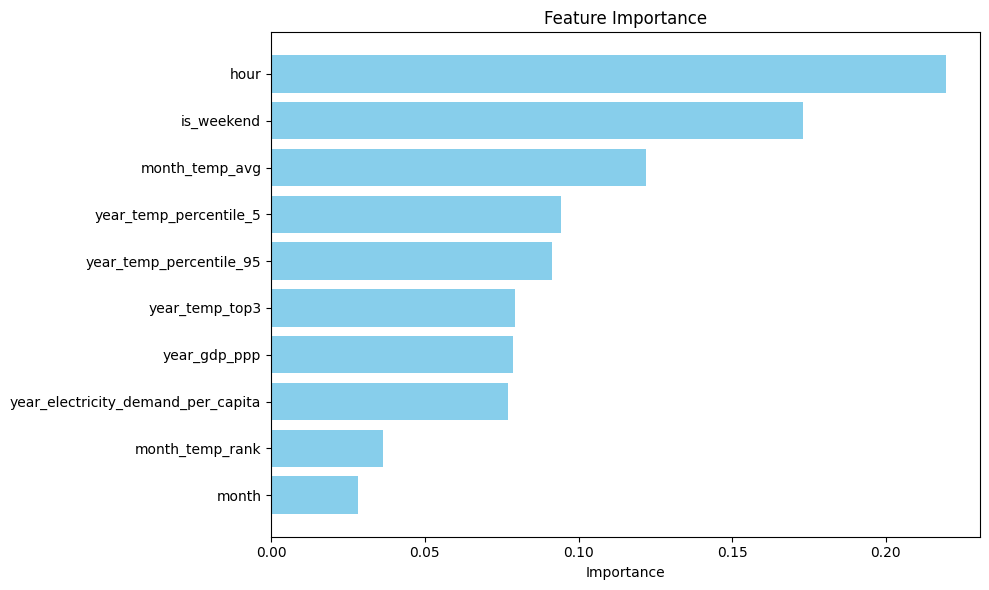

In [75]:
# Get feature importance
importance = xgb_model.feature_importances_
feature_names = features.columns

# Sort features by importance
indices = numpy.argsort(importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(len(importance)), importance[indices], color="skyblue")
plt.yticks(range(len(importance)), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.tight_layout()

plt.savefig(
    os.path.join(figure_directory, "feature_importance.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## Cross-validation

Validate the approach by performing k-fold cross-validation.

In [76]:
from sklearn.model_selection import LeaveOneGroupOut, cross_validate

In [77]:
combined_dataset["country_code"].unique()

array(['AR', 'AU', 'AT', 'BE', 'BA', 'BR', 'BG', 'CA', 'CL', 'HR', 'CY',
       'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IT',
       'KE', 'KR', 'LV', 'LT', 'MK', 'MX', 'NL', 'NZ', 'NO', 'PL', 'PT',
       'RO', 'SA', 'SK', 'SI', 'ES', 'LK', 'SE', 'CH', 'TR', 'GB', 'RS'],
      dtype=object)

In [78]:
# Perform cross-validation
cv_results = cross_validate(
    xgb_model,
    features,
    target,
    groups=groups,
    cv=LeaveOneGroupOut(),
    scoring=["neg_mean_absolute_error"],
    return_train_score=True,
    return_indices=True,
    return_estimator=True,
    n_jobs=-1,
)

/workspaces/electric-demand-data/models/xgboost/.venv/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/workspaces/electric-demand-data/models/xgboost/.venv/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: 

In [79]:
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'indices', 'test_neg_mean_absolute_error', 'train_neg_mean_absolute_error'])

In [80]:
cv_results

{'fit_time': array([6.05204082, 6.45542932, 6.96855521, 6.67082214, 6.01629925,
        6.10524416, 6.94187379, 6.22836208, 7.2595005 , 6.92368126,
        6.42265105, 6.20484924, 4.45392203, 5.98145008, 5.38424659,
        5.2928009 , 5.28227687, 5.45978355, 5.56384659, 5.66025853,
        5.83328676, 5.79803801, 5.57889867, 5.0023644 , 4.22755504,
        5.18237615, 5.36177254, 5.34863091, 4.69765902, 4.55145216,
        4.58137727, 5.33954883, 5.3908453 , 5.37305021, 5.30328941,
        5.10285854, 3.84515452, 3.12888908, 4.00903153, 3.22103548,
        3.27058411, 3.84405947, 3.95986605, 3.45574903]),
 'score_time': array([0.06165338, 0.04082704, 0.0637486 , 0.04819107, 0.04901171,
        0.07049346, 0.04149556, 0.05064464, 0.03801394, 0.04537225,
        0.08491588, 0.04924178, 0.04666615, 0.05482078, 0.05803108,
        0.03582644, 0.05279636, 0.04154086, 0.04184461, 0.04741168,
        0.04051948, 0.04497647, 0.04123998, 0.04335737, 0.04809308,
        0.05844378, 0.05296636, 

In [81]:
cv_results["indices_train"] = cv_results["indices"]["train"]
cv_results["indices_test"] = cv_results["indices"]["test"]

In [82]:
# Assuming 'cv_results' is your original dictionary and 'indices' is the key you want to exclude
cv_results_filtered = {k: v for k, v in cv_results.items() if k != "indices"}

# Create DataFrame from the filtered dictionary
df_cv_results = pandas.DataFrame(cv_results_filtered)

df_cv_results["test_mae"] = -df_cv_results["test_neg_mean_absolute_error"]
df_cv_results["train_mae"] = -df_cv_results["train_neg_mean_absolute_error"]

In [83]:
list_test_group_id = []
for test_indices in cv_results["indices"]["test"]:
    list_test_group_id.append(groups[test_indices[0]])

df_cv_results["group_id"] = list_test_group_id

In [84]:
df_cv_results.head()

,fit_time,score_time,estimator,test_neg_mean_absolute_error,train_neg_mean_absolute_error,indices_train,indices_test,test_mae,train_mae,group_id
0,6.052041,0.061653,"XGBRegressor(base_score=None, booster=None, ca...",-0.091180,-0.041739,"[8760, 8761, 8762, 8763, 8764, 8765, 8766, 876...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.091180,0.041739,AR
1,6.455429,0.040827,"XGBRegressor(base_score=None, booster=None, ca...",-0.078742,-0.041988,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[17520, 17521, 17522, 17523, 17524, 17525, 175...",0.078742,0.041988,AT
2,6.968555,0.063749,"XGBRegressor(base_score=None, booster=None, ca...",-0.087175,-0.042607,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[8760, 8761, 8762, 8763, 8764, 8765, 8766, 876...",0.087175,0.042607,AU
3,6.670822,0.048191,"XGBRegressor(base_score=None, booster=None, ca...",-0.087893,-0.042492,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[35040, 35041, 35042, 35043, 35044, 35045, 350...",0.087893,0.042492,BA
4,6.016299,0.049012,"XGBRegressor(base_score=None, booster=None, ca...",-0.052818,-0.042503,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[26280, 26281, 26282, 26283, 26284, 26285, 262...",0.052818,0.042503,BE


### Visualizations

In [85]:
def plot_cv_timeseries(features, target, country_cv_results):
    current_estimator = country_cv_results["estimator"]
    current_country_features = features.iloc[country_cv_results["indices_test"]]

    country_predictions = current_estimator.predict(current_country_features)
    country_ground_truth = target.iloc[country_cv_results["indices_test"]]

    # Create a new figure
    plt.figure(figsize=(15, 8))

    # Plot the ground truth
    plt.plot(
        country_ground_truth.values, label="Ground Truth", color="lightgreen", alpha=0.7
    )

    # Plot the predictions
    plt.plot(country_predictions, label="Predictions", color="skyblue", alpha=0.7)

    # Plot the absolute difference between predictions and ground truth
    plt.bar(
        numpy.arange(0, 8760),
        abs(country_predictions - country_ground_truth).values,
        label="Difference",
        color="lightcoral",
        alpha=0.7,
    )

    country_code = country_cv_results["group_id"]
    plt.title(f"{country_code}: Actual vs Predicted Hourly Demand")

    plt.ylabel("Normalized Hourly Demand")
    plt.ylim(0, 2)
    plt.legend(loc="upper right")

    plt.xticks(numpy.arange(0, 8761, 730), numpy.arange(0, 13))  # 730 hours ≈ 1 month
    plt.xlabel("Months")

    # Add grid for better readability
    plt.grid(True, linestyle="--", alpha=0.2)

    # Improve layout
    # plt.tight_layout()

    # Save the figure
    plt.savefig(
        os.path.join(figure_directory, f"{country_code}_cv_comparison.png"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.close()

In [86]:
for _, row in tqdm(
    df_cv_results.iterrows(),
    desc="Plotting cross-validation timeseries",
    total=len(df_cv_results),
):
    plot_cv_timeseries(features, target, row)

Plotting cross-validation timeseries: 100%|█████████████████████████████████████████████████████████████████████| 44/44 [06:06<00:00,  8.34s/it]


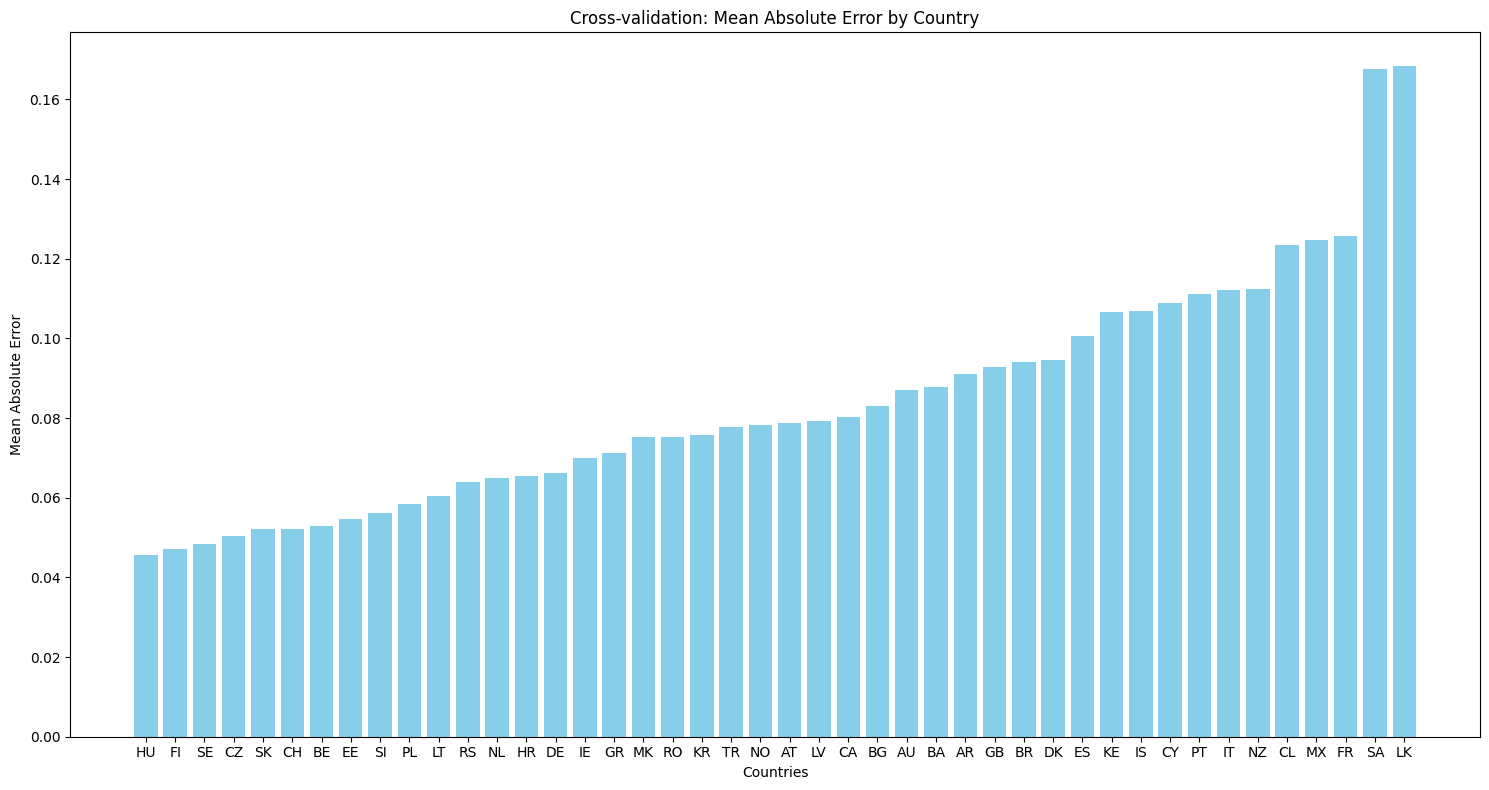

In [87]:
# Plot the cross-validation test set error metrics

df_sorted = df_cv_results.sort_values("test_mae")

# Create the bar plot
fig, ax = plt.subplots(figsize=(15, 8))
bars = ax.bar(range(len(df_sorted)), df_sorted["test_mae"], color="skyblue")
x = numpy.arange(len(df_sorted))

# Customize the plot
ax.set_xlabel("Countries")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Cross-validation: Mean Absolute Error by Country")
ax.set_xticks(x)
ax.set_xticklabels(df_sorted["group_id"])


plt.tight_layout()

plt.savefig(
    os.path.join(figure_directory, "cv_mae_per_country.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

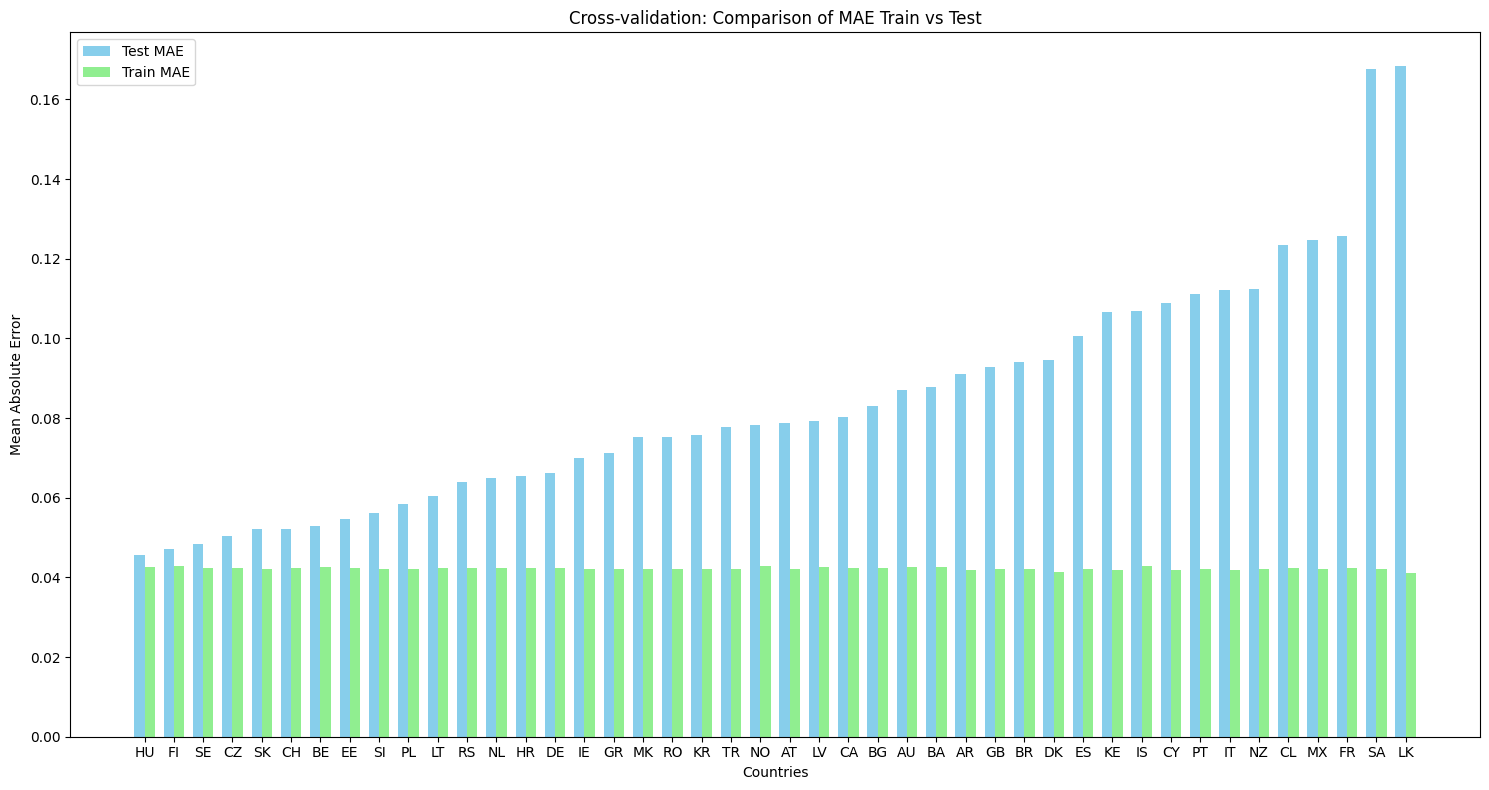

In [88]:
# Plot comparison between train and test error metrics

df_sorted = df_cv_results.sort_values("test_mae")

# Create the bar plot
fig, ax = plt.subplots(figsize=(15, 8))

width = 0.35
x = numpy.arange(len(df_sorted))

# Create the bars
bars1 = ax.bar(
    x - width / 2, df_sorted["test_mae"], width, label="Test MAE", color="skyblue"
)
bars2 = ax.bar(
    x + width / 2, df_sorted["train_mae"], width, label="Train MAE", color="lightgreen"
)

# Customize the plot
ax.set_xlabel("Countries")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Cross-validation: Comparison of MAE Train vs Test")
ax.set_xticks(x)
ax.set_xticklabels(df_sorted["group_id"])


plt.legend()
plt.tight_layout()

plt.savefig(
    os.path.join(figure_directory, "cv_mae_comparison.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## Inference

In [89]:
# Use the weather year of 2015, same as the training dataset
weather_dataset = pandas.read_parquet("./data/train/train_dataset.parquet")

# Drop unnecessary columns
weather_dataset.drop(
    columns=[
        "normalized_hourly_demand",
        "GDP_PPP",
        "ElectricityPerCapita",
    ],
    inplace=True,
)

In [90]:
weather_dataset.shape

(385440, 9)

In [91]:
weather_dataset.columns

Index(['country_code', 'Local hour of the day', 'Local month of the year',
       'Monthly average temperature (K)', 'Monthly average temperature rank',
       '5 percentile temperature (K)', '95 percentile temperature (K)',
       'weekend_indicator', 'Temperature top_3 (K)'],
      dtype='object')

In [92]:
weather_dataset.head()

,country_code,Local hour of the day,Local month of the year,Monthly average temperature (K),Monthly average temperature rank,5 percentile temperature (K),95 percentile temperature (K),weekend_indicator,Temperature top_3 (K)
0,AR,0,1,296.27414,3.0,280.375854,301.169482,0,293.81628
1,AR,1,1,296.27414,3.0,280.375854,301.169482,0,294.05078
2,AR,2,1,296.27414,3.0,280.375854,301.169482,0,294.06946
3,AR,3,1,296.27414,3.0,280.375854,301.169482,0,293.74756
4,AR,4,1,296.27414,3.0,280.375854,301.169482,0,293.55545


In [93]:
def get_year_ElectricityPerCapita(
    year: int, df_EPC: pandas.DataFrame
) -> pandas.DataFrame:
    df_result = df_EPC[["country_code", year]].copy()
    df_result.rename(columns={year: "ElectricityPerCapita"}, inplace=True)
    return df_result

In [94]:
def get_year_GDP_PPP(year: int, df_GDP_PPP: pandas.DataFrame) -> pandas.DataFrame:
    df_result = df_GDP_PPP[["country_code", year]].copy()
    df_result.rename(columns={year: "GDP_PPP"}, inplace=True)
    return df_result

In [95]:
future_prediction_years = numpy.arange(2020, 2100 + 1, 5)

df_all_prediction_data = pandas.DataFrame()
for year in future_prediction_years:
    df_GDP_PPP_current_year = get_year_GDP_PPP(year, GDP_PPP)

    # Merge GDP with combined weather + electricity per capita data
    df_combine_weather_GDP = pandas.merge(
        weather_dataset, df_GDP_PPP_current_year, on=["country_code"]
    ).copy()

    df_EPC_current_year = get_year_ElectricityPerCapita(year, ElectricityPerCapita)
    df_EPC_current_year["year"] = year

    # Merge electricity per capita with weather data
    df_combine_weather_GDP_EDP = pandas.merge(
        df_combine_weather_GDP, df_EPC_current_year, on=["country_code"]
    ).copy()

    df_all_prediction_data = pandas.concat(
        [df_all_prediction_data, df_combine_weather_GDP_EDP], ignore_index=True
    )

In [96]:
df_all_prediction_data.shape

(6552480, 12)

In [97]:
df_all_prediction_data.head()

,country_code,Local hour of the day,Local month of the year,Monthly average temperature (K),Monthly average temperature rank,5 percentile temperature (K),95 percentile temperature (K),weekend_indicator,Temperature top_3 (K),GDP_PPP,ElectricityPerCapita,year
0,AR,0,1,296.27414,3.0,280.375854,301.169482,0,293.81628,19688.602933,4309.1419,2020
1,AR,1,1,296.27414,3.0,280.375854,301.169482,0,294.05078,19688.602933,4309.1419,2020
2,AR,2,1,296.27414,3.0,280.375854,301.169482,0,294.06946,19688.602933,4309.1419,2020
3,AR,3,1,296.27414,3.0,280.375854,301.169482,0,293.74756,19688.602933,4309.1419,2020
4,AR,4,1,296.27414,3.0,280.375854,301.169482,0,293.55545,19688.602933,4309.1419,2020


In [107]:
df_all_prediction_data.columns = [
    'country_code',
    "hour",
    "month",
    "month_temp_avg",
    "month_temp_rank",
    "year_temp_percentile_5",
    "year_temp_percentile_95",
    "is_weekend",
    "year_temp_top3",
    "year_gdp_ppp",
    "year_electricity_demand_per_capita",
    'year'
]

# Reindex to new column order
new_order = [
    'country_code',
    "is_weekend",
    "hour",
    "month",
    "month_temp_avg",
    "month_temp_rank",
    "year_electricity_demand_per_capita",
    "year_gdp_ppp",
    "year_temp_percentile_5",
    "year_temp_percentile_95",
    "year_temp_top3",
    "year"
]
df_all_prediction_data = df_all_prediction_data.reindex(columns=new_order)

In [108]:
df_all_prediction_data.head()

,country_code,is_weekend,hour,month,month_temp_avg,month_temp_rank,year_electricity_demand_per_capita,year_gdp_ppp,year_temp_percentile_5,year_temp_percentile_95,year_temp_top3,year
0,AR,0,0,1,296.27414,3.0,4309.1419,19688.602933,280.375854,301.169482,293.81628,2020
1,AR,0,1,1,296.27414,3.0,4309.1419,19688.602933,280.375854,301.169482,294.05078,2020
2,AR,0,2,1,296.27414,3.0,4309.1419,19688.602933,280.375854,301.169482,294.06946,2020
3,AR,0,3,1,296.27414,3.0,4309.1419,19688.602933,280.375854,301.169482,293.74756,2020
4,AR,0,4,1,296.27414,3.0,4309.1419,19688.602933,280.375854,301.169482,293.55545,2020


In [109]:
trained_xgb_model = XGBRegressor()
trained_xgb_model.load_model("./data/train/xgboost_model.bin")

In [110]:
df_all_prediction_data["prediction"] = trained_xgb_model.predict(
    df_all_prediction_data.loc[
        :, ~df_all_prediction_data.columns.isin(["country_code", "year"])
    ]
)

In [111]:
df_all_prediction_data

,country_code,is_weekend,hour,month,month_temp_avg,month_temp_rank,year_electricity_demand_per_capita,year_gdp_ppp,year_temp_percentile_5,year_temp_percentile_95,year_temp_top3,year,prediction
0,AR,0,0,1,296.27414,3.0,4309.141900,19688.602933,280.375854,301.169482,293.81628,2020,0.972761
1,AR,0,1,1,296.27414,3.0,4309.141900,19688.602933,280.375854,301.169482,294.05078,2020,0.947933
2,AR,0,2,1,296.27414,3.0,4309.141900,19688.602933,280.375854,301.169482,294.06946,2020,0.924961
3,AR,0,3,1,296.27414,3.0,4309.141900,19688.602933,280.375854,301.169482,293.74756,2020,0.903913
4,AR,0,4,1,296.27414,3.0,4309.141900,19688.602933,280.375854,301.169482,293.55545,2020,0.907159
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6552475,RS,0,19,12,276.41727,11.0,18025.827724,87900.763223,273.438550,303.633655,269.24686,2100,1.247645
6552476,RS,0,20,12,276.41727,11.0,18025.827724,87900.763223,273.438550,303.633655,269.06064,2100,1.245977
6552477,RS,0,21,12,276.41727,11.0,18025.827724,87900.763223,273.438550,303.633655,267.45764,2100,1.263235
6552478,RS,0,22,12,276.41727,11.0,18025.827724,87900.763223,273.438550,303.633655,267.25693,2100,1.293559


In [112]:
os.makedirs("./data/predictions", exist_ok=True)

In [113]:
# df_all_prediction_data.to_parquet("./predictions/predictions_2020_2100.parquet")

In [114]:
# Get annual demand for the selected countries
df_annual_demand = pandas.read_csv(
    "./data/toktarova_et_al_2019/AnnualDemand.csv", index_col=0, header=1
)

In [115]:
df_annual_demand.columns = [
    int(float(col_name)) if col_name.split(".")[0].isdigit() else col_name
    for col_name in df_annual_demand.columns
]

In [116]:
toktarova_indices = numpy.loadtxt("./data/train/toktarova_indices.txt")

In [117]:
df_sel_annual_demand = df_annual_demand.loc[toktarova_indices]

In [118]:
df_sel_annual_demand.insert(1, "country_code", ElectricityPerCapita["country_code"])

In [119]:
df_sel_annual_demand = df_sel_annual_demand.dropna(axis=1)

In [120]:
df_sel_annual_demand.head()

,Countries,country_code,Continents,SRegion,2015,2016,2017,2018,2019,2020,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
Code,,,,,,,,,,,,,,,,,,,,,
9,Argentina,AR,Americas,S America,132.106768,146.917582,157.969787,169.840986,182.553779,196.139212,...,1051.452210,1052.556102,1053.484556,1054.208695,1054.770971,1055.159993,1055.382027,1055.461079,1055.384970,1055.441905
11,Australia,AU,Asia-Pacific,SE Asia,215.362641,221.691452,229.655927,237.845431,246.261792,254.915222,...,741.172763,744.023443,746.834134,749.588230,752.269015,754.895701,757.451408,759.937192,762.336011,764.666823
12,Austria,AT,Europe,Europe,69.617944,71.923996,73.675834,75.473826,77.298694,79.184224,...,150.046436,150.086541,150.136143,150.177775,150.229865,150.274864,150.313162,150.363159,150.407200,150.463667
19,Belgium,BE,Europe,Europe,85.222869,87.004400,88.529655,90.092352,91.678415,93.272885,...,232.786119,233.521964,234.213807,234.862902,235.506290,236.109422,236.709351,237.253318,237.796323,238.303403
25,Bosnia-Herzegovina,BA,Europe,Europe,12.365538,12.087634,12.314708,12.561788,12.836792,13.134288,...,36.341778,36.162152,35.956029,35.777373,35.573371,35.398174,35.198647,35.011112,34.818086,34.629237


In [121]:
for year in range(2015, 2100 + 1):
    # Multiply by 1 million to get MW, divide by hours in a year
    df_sel_annual_demand[f"{year}_mean"] = (
        df_sel_annual_demand[[year]].mul(1000000).div(8760).copy()
    )

In [122]:
df_sel_annual_demand.head()

,Countries,country_code,Continents,SRegion,2015,2016,2017,2018,2019,2020,...,2091_mean,2092_mean,2093_mean,2094_mean,2095_mean,2096_mean,2097_mean,2098_mean,2099_mean,2100_mean
Code,,,,,,,,,,,,,,,,,,,,,
9,Argentina,AR,Americas,S America,132.106768,146.917582,157.969787,169.840986,182.553779,196.139212,...,120028.791056,120154.806215,120260.794115,120343.458361,120407.645068,120452.054052,120477.400391,120486.424523,120477.736342,120484.235762
11,Australia,AU,Asia-Pacific,SE Asia,215.362641,221.691452,229.655927,237.845431,246.261792,254.915222,...,84608.762878,84934.182985,85255.038090,85569.432672,85875.458284,86175.308314,86467.055698,86750.821013,87024.658834,87290.733238
12,Austria,AT,Europe,Europe,69.617944,71.923996,73.675834,75.473826,77.298694,79.184224,...,17128.588602,17133.166771,17138.829054,17143.581674,17149.527987,17154.664844,17159.036791,17164.744201,17169.771691,17176.217720
19,Belgium,BE,Europe,Europe,85.222869,87.004400,88.529655,90.092352,91.678415,93.272885,...,26573.757827,26657.758439,26736.735996,26810.833597,26884.279657,26953.130319,27021.615446,27083.712072,27145.699021,27203.584836
25,Bosnia-Herzegovina,BA,Europe,Europe,12.365538,12.087634,12.314708,12.561788,12.836792,13.134288,...,4148.604753,4128.099523,4104.569484,4084.174958,4060.887096,4040.887437,4018.110346,3996.702276,3974.667302,3953.109257


In [123]:
list_countries = df_all_prediction_data["country_code"].unique()
list_years = df_all_prediction_data["year"].unique()

In [124]:
list_years_col = [str(year) + "_mean" for year in list_years]

In [125]:
df_sel_mean_annual_demand = df_sel_annual_demand[["country_code"] + list_years_col]

In [126]:
df_sel_mean_annual_demand[df_sel_mean_annual_demand["country_code"] == "BR"]

,country_code,2020_mean,2025_mean,2030_mean,2035_mean,2040_mean,2045_mean,2050_mean,2055_mean,2060_mean,2065_mean,2070_mean,2075_mean,2080_mean,2085_mean,2090_mean,2095_mean,2100_mean
Code,,,,,,,,,,,,,,,,,,
28,BR,83399.761294,105239.864159,133486.735794,168162.004665,207902.677115,250064.638235,291509.529781,329549.128941,362278.775045,387775.117781,406444.143363,418372.630484,424408.82207,425675.276276,423462.394066,418693.241231,412496.679483


In [127]:
for country in tqdm(list_countries):
    df_country_predictions = df_all_prediction_data[
        df_all_prediction_data["country_code"] == country
    ].copy()

    df_country_annual_demand = df_sel_mean_annual_demand[
        df_sel_mean_annual_demand["country_code"] == country
    ]

    # Add a new column 'hour_of_year' that increments within each year
    df_country_predictions["hour_of_year"] = df_country_predictions.groupby(
        "year"
    ).cumcount()

    df_country_selection = df_country_predictions[
        ["country_code", "year", "hour_of_year", "prediction"]
    ].copy()

    # Multiply the predictions by the mean annual demand
    for year in future_prediction_years:
        year_mean_demand = df_country_annual_demand[f"{year}_mean"].values[0]
        mask = df_country_selection["year"] == year
        df_country_selection.loc[mask, "prediction"] *= year_mean_demand

    df_country_selection.to_parquet(
        f"./data/predictions/{country}_{future_prediction_years.min()}_to_{future_prediction_years.max()}.parquet",
        index=False,
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:28<00:00,  1.57it/s]
